## Speckle Data Pack
### Concrete And Cement Content
This example explains how to quantify materials with concrete and cement content accross the whole portfolio.

In [1]:
%%capture
# capture turns off the output for this cell which would just be the pip install log
%pip install specklepy
%pip install pandas
%pip install pandasai

In [2]:
from specklepy.api.wrapper import StreamWrapper

# Speckle Data Pack I project (stream) link
stream_url = "https://speckle.xyz/streams/729cb7c74b"

# wrapper
wrapper = StreamWrapper(stream_url)


In [9]:
from specklepy.api import operations

# get project (stream) data
stream = wrapper.get_client().stream.get(id=wrapper.stream_id, branch_limit=40)

data = []

# models (branches) to skip
exclude_models = ['main', 'all_in_one']

for branch in stream.branches.items:
    
    if branch.commits.items and branch.name not in exclude_models:
        # get obj id from the latest version (commit)
        obj_id = branch.commits.items[0].referencedObject

        # receive objects from speckle
        commit_data = operations.receive(
            obj_id=obj_id, remote_transport=wrapper.get_transport()
        )
        data.append([commit_data, branch.name])
    

In [4]:
# get list of materials containing cement and concrete

concrete = []

for item in data:
    
    materials = item[0]['@Materials']

    for material in materials:

        if 'concrete' in material['name'].lower() or 'cement' in material['name'].lower():

            if material['name'] not in concrete:
                concrete.append(material['name'])

In [ ]:
# create data table

import pandas as pd

table = {'Type':[], 'Level':[], 'Model':[], 'Material':[], 'Volume':[]}

# object types to look for
types = ['Floors', 'Walls', 'Columns']

for item in data: 

    elements = item[0]['elements']

    # get type collections
    for element in elements:
        if element['name'] in types:
            for el in element['elements']:
                for mat in el['materialQuantities']:
                    table['Type'].append(el['type'])
                    table['Level'].append(el['level']['name'])
                    table['Model'].append(item[1])
                    table['Material'].append(mat['material']['name'])
                    
                    # make sure the volume value is a number and convert to cubic millimeters to cubic meters
                    table['Volume'].append(float(mat['volume'])/1.0E+9)

# create data frame 
df = pd.DataFrame(table)

With table created, we can now slice and dice the room data and look for answers. What materials are there in project portfolio? How many objects per material are there?

In [ ]:
# number of elements per material in all models
df['Material'].value_counts()

Gypsum Wall Board                       568
Concrete Masonry Units                  269
Metal Stud Layer                        232
Brick, Common                           214
Plaster                                 152
Vapour Retarder                         110
Cavity Fill                             110
Air                                     104
Fiberglass Batt                          80
Concrete Masonry Units _High Density     48
Plywood, Sheathing                       41
Concrete Masonry Units _Low Density      32
Vapor Retarder                           32
Concrete, Sand/Cement Screed             30
Aluminum                                 24
Concrete, Cast In Situ                   21
Damp-proofing                            21
Default Floor                            21
Metal Deck                               18
Concrete, Cast-in-Place - C15            18
Wood Sheathing, Chipboard                12
Structure, Timber Joist/Rafter Layer     12
Structure, Steel Bar Joist Layer

What is the total volumne of materials containg concrete or cement? 

In [ ]:
# total volume of materials with concrete and cement content
df.loc[df['Material'].isin(concrete)].sum()['Volume'].round(0)

3049.0

What is the volumne of concrete or cementa materials in each model?

In [ ]:
# filter materials with concrete content, then group by model and sum volume
df.loc[df['Material'].isin(concrete)].groupby('Model')['Volume'].sum().round(0)

Model
sb2201    102.0
sb2202    116.0
sb2203    131.0
sb2204    147.0
sb2205    137.0
sb2206    146.0
sb2207    146.0
sb2208    166.0
sb2209    177.0
sb2210    167.0
sb2301    116.0
sb2302    135.0
sb2303    155.0
sb2304    145.0
sb2305    135.0
sb2306    122.0
sb2307     44.0
sb2308     40.0
sb2309     40.0
sb2310     42.0
sb2401     82.0
sb2402     91.0
sb2403     82.0
sb2404     56.0
sb2405     61.0
sb2406     59.0
sb2407     52.0
sb2408     48.0
sb2409     55.0
sb2410     52.0
Name: Volume, dtype: float64

<Axes: xlabel='Model', ylabel='concrete & cement content m³'>

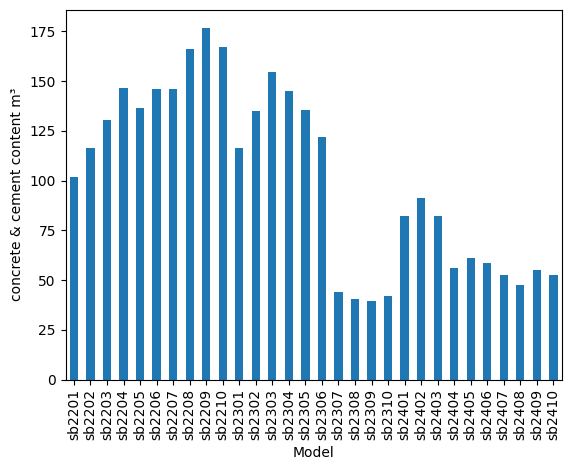

In [ ]:
df.loc[df['Material'].isin(concrete)].groupby('Model')['Volume'].sum().plot(ylabel='concrete & cement content m³', kind='bar')

PandasAI integrates LLMs so you can simply as questions and in this case, ChatGPT will answer.

In [ ]:
# load environment variables 
from decouple import config


In [ ]:
import pandas as pd
from pandasai import SmartDataframe

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=config('OPENAI_TOKEN'))

df = SmartDataframe(df, config={"llm": llm})

In [ ]:
df.chat('Count volume of materials with concrete or cement content')

'The total volume of materials with concrete or cement content is 3048.821990970001.'

In [ ]:
df.chat('Show unique types with material that contains concrete or cement')

'Count of materials with concrete or cement content: 427\n\nUnique types with material that contains concrete or cement:\nType\nBeam and Block 200mm                       [concrete masonry units, concrete, sand/cement...\nCW 102-50-100p                                                      [concrete masonry units]\nCW 102-50-140p                                                      [concrete masonry units]\nCW 102-50-215p                                                      [concrete masonry units]\nCW 102-85-140p                                                      [concrete masonry units]\nConcrete-Domestic 425mm                    [concrete, cast in situ, concrete, sand/cement...\nFloor-Upper_160mmConc-CorusComFlor51                         [concrete, cast-in-place - c15]\nGeneric - 200mm Masonry                                             [concrete masonry units]\nGeneric - 300mm Masonry                                             [concrete masonry units]\nInsitu Concrete 225mm     